[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/aws/studio-lab-examples/blob/main/computer-vision/kmnist/cv-kminst.ipynb)

# Train an image classification model with PyTorch 

## Background

Image classification (or Image recognition) is a subdomain of computer vision in which an algorithm looks at an image and assigns it a tag from a collection of predefined tags or categories that it has been trained on.

Vision is responsible for 80-85 percent of our perception of the world, and we, as human beings, trivially perform classification daily on whatever data we come across.

Therefore, emulating a classification task with the help of neural networks is one of the first uses of computer vision that researchers thought about.


## Pytorch

[PyTorch](https://pytorch.org/) is an open-source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR). It is free and open-source software released under the Modified BSD license.

## KMINST dataset

In this notebook we will use the KMINST dataset
https://pytorch.org/vision/stable/datasets.html#torchvision-datasets
    
## Steps in this notebook

The main steps are:
- install packages
- load dataset, what's train and test loader
- print out 1 image from KMINST dataset, with which library, 
- initiate the NN model, what's neural network, furthor reading: mlu-cv course
- train a model with config
- test a model 
- print a figure with train and test loss

![KMIST dataset picture](https://raw.githubusercontent.com/rois-codh/kmnist/master/images/kmnist_examples.png)

- Install python packages for later use

    - **torch**: for install [PyTorch](https://pytorch.org/). PyTorch is a Python package that provides two high-level features: (1) Tensor computation (like NumPy) with strong GPU acceleration (2) Deep neural networks built on a tape-based autograd system

    - torchvision: 
    - torchsummary: 
    - matplotlib: 
    
Before running this notebook we need to install the required Python packages by opening a terminal window (click on File/New/Terminal) going to the location where the env_cv.yml file is located and launching the following two commands:
- conda env create -f env_cv.yml
- conda activate cv

After that we also need to switch the notebook kernel (click on Kernel/Change Kernel...) to **.conda-cv:Python**    

In [1]:
%pip install torch 
%pip install torchvision
%pip install torchsummary
%pip install matplotlib
%pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision

In [3]:
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu" 

In [4]:
import os
results_dir='results'
if not os.path.isdir(results_dir):
    !mkdir -p {results_dir}

In [5]:
## Create dataloader, in PyTorch, we feed the trainer data with use of dataloader
## We create dataloader with dataset from torchvision, 
## and we dont have to download it seperately, all automatically done

# Define batch size, batch size is how much data you feed for training in one iteration
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 1024 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets
train_dataset = torchvision.datasets.KMNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.KMNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

0it [00:00, ?it/s]

Extracting dataset/KMNIST/raw/train-images-idx3-ubyte.gz to dataset/KMNIST/raw


0it [00:00, ?it/s]

Extracting dataset/KMNIST/raw/train-labels-idx1-ubyte.gz to dataset/KMNIST/raw


0it [00:00, ?it/s]

Extracting dataset/KMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/KMNIST/raw


0it [00:00, ?it/s]

Extracting dataset/KMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/KMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Label: tensor(3)


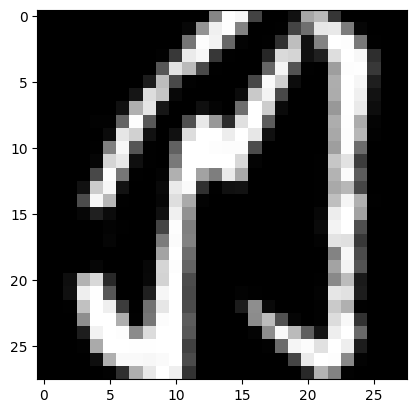

In [6]:
# import library

import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0][0]
# show the data
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0]))

In [7]:
## Now we can start to build our CNN model
## We first import the pytorch nn module and optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## Then define the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input channel 1, output channel 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        #input channel 10, output channel 20
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        #dropout layer
        self.conv2_drop = nn.Dropout2d()
        #fully connected layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.5
model = CNN().to(device) #using cpu here
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [9]:

from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [10]:
n_epochs = 3
log_interval = 100
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if torch.cuda.is_available():  
            output = model(data.cuda())
            loss = F.nll_loss(output, target.cuda())
        else:
            output = model(data)
            loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(loss.item())
    train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    torch.save(model.state_dict(), './results/model.pth')
    torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [12]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available(): 
                output = model(data.cuda())
                test_loss += F.nll_loss(output, target.cuda(), size_average=False).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.cuda().data.view_as(pred)).sum()
            else:
                output = model(data)
                test_loss += F.nll_loss(output, target, size_average=False).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()                
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3171, Accuracy: 1062/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305246
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.224849
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.662956
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.703619
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.172819
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.188190
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.000410
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.377215
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.884381
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.824386

Test set: Avg. loss: 1.2027, Accuracy: 6102/10000 (61%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.101950
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.812221
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.633475
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.553969
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.165337
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.599698
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.880249
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.611

Text(0, 0.5, 'negative log likelihood loss')

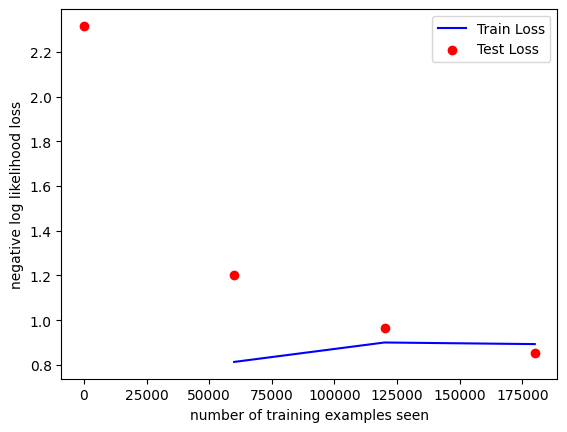

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig